Import Libraries

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from VGG import vgg13_bn
%matplotlib inline

Prepare CIFAR Dataset

In [2]:
# Download CIFAR 10 DATASET

data_dir = "./data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2) # num_workers is the number of CPU cores
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Data Loaded Completely")
print("Batch Size : {}, Total Images : {}".format(batch_size,batch_size*len(trainloader)))

Files already downloaded and verified
Files already downloaded and verified
Data Loaded Completely
Batch Size : 10, Total Images : 50000


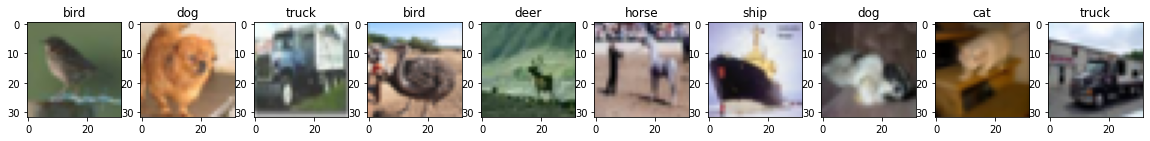

In [3]:
# Show sample imgs

sample_imgs, sample_labels = next(iter(trainloader))
sample_labels = [i.item() for i in sample_labels]

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow((img * 255).astype(np.uint8))

plt.figure(figsize=(20,60))
for i in range(batch_size):
    plt.subplot(1,10,i+1)
    plt.gca().title.set_text(str(classes[sample_labels[i]]))
    imshow(sample_imgs[i])
plt.show()

Implementation of MC Dropout with pretrained VGG Net

In [4]:
def predict_label(model, X):
    model = model.eval()
    outputs = model(X)
    _, pred = torch.max(outputs.data, 1)
    return pred

def predict_uncertainty(model, X, T=100):
    labels = []
    si = []
    so = []
    model = model.train()
    for i in range(100):
        _si = model(X)
        _so = F.softmax(_si,dim=1)
        _, label = torch.max(_si.data, 1)
        labels.append(label)
        si.append(_si.data.numpy())
        so.append(_so.data.numpy())
    return labels, si, so

In [5]:
device = torch.device('cuda')
VGGModel = vgg13_bn(pretrained=True, device=device)

In [6]:
X_test, y_test = iter(testloader).next()
y_test_pred = predict_label(VGGModel,X_test)
test_accuracy = sum(y_test == y_test_pred).item() / len(y_test)
print("Test Accuracy : {}%".format(test_accuracy * 100))


Test Accuracy : 87.81%


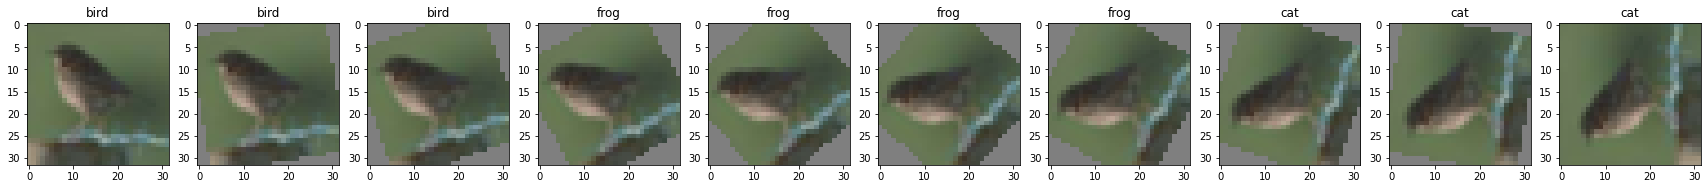

In [7]:
from scipy.ndimage.interpolation import rotate

X_test, y_test = iter(testloader).next()

def Rot(img,i):
    img = img.numpy()
    img_rot = rotate(img,10*i,reshape=False,axes=(1,2))
    img_final = torch.Tensor(img_rot.copy())
    return img_final

plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.gca().title.set_text("Rotate : {}".format(10*i))
    X = Rot(X_test[0],i).reshape(1,3,32,32)
    idx = predict_label(VGGModel,X)
    A = classes[idx.item()]
    plt.gca().title.set_text(str(A))
    X = X.reshape(3,32,32)
    imshow(X)
plt.show()

In [8]:
X0 = Rot(X_test[0],0)
X1 = Rot(X_test[0],1)
X2 = Rot(X_test[0],2)
X3 = Rot(X_test[0],3)
X4 = Rot(X_test[0],4)
X5 = Rot(X_test[0],5)
X6 = Rot(X_test[0],6)
X7 = Rot(X_test[0],7)
X8 = Rot(X_test[0],8)
X9 = Rot(X_test[0],9)
X = [X0,X1,X2,X3,X4,X5,X6,X7,X8,X9]

li_labels = []
li_si = []
li_so = []

for i in range(10):
    a,b,c = predict_uncertainty(VGGModel,X[i].reshape(1,3,32,32))
    li_labels.append(a)
    li_si.append(b)
    li_so.append(c)

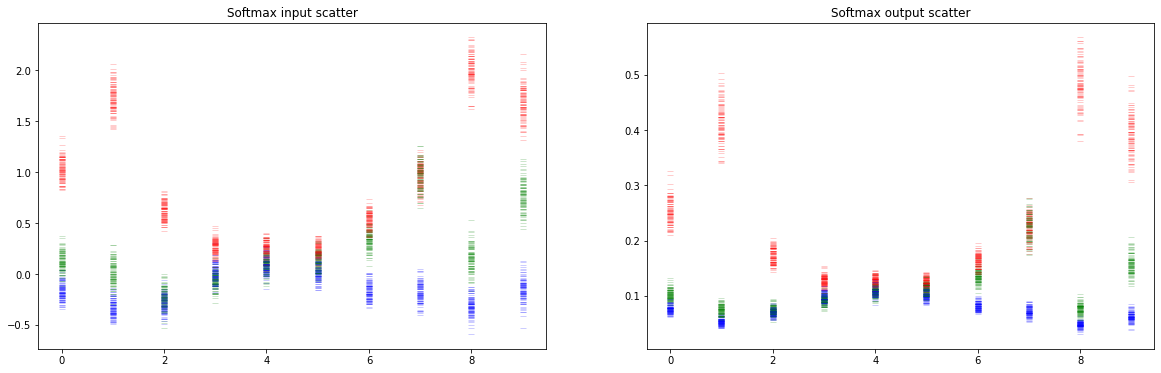

In [9]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
for i in range(10):
    for j in li_si[i]:
        plt.scatter(i,j.flatten()[8],color='b',marker='_',linewidth=None,alpha=0.2, label='ship')
        plt.scatter(i,j.flatten()[3],color='r',marker='_',linewidth=None,alpha=0.2, label='cat')
        plt.scatter(i,j.flatten()[5],color='g',marker='_',linewidth=None,alpha=0.2, label='dog')
plt.title('Softmax input scatter')
plt.subplot(1,2,2)
for i in range(10):
    for j in li_so[i]:
        plt.scatter(i,j.flatten()[8],color='b',marker='_',linewidth=None,alpha=0.2, label='ship')
        plt.scatter(i,j.flatten()[3],color='r',marker='_',linewidth=None,alpha=0.2, label='cat')
        plt.scatter(i,j.flatten()[5],color='g',marker='_',linewidth=None,alpha=0.2, label='dog')
plt.title('Softmax output scatter')
plt.show()

Prepare SVHN Dataset

Data shape :  (73257, 3, 32, 32)
Data type :  <class 'numpy.ndarray'>


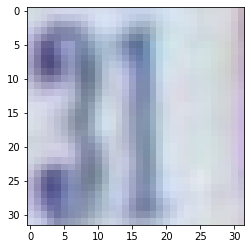

Label :  [1]


In [10]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
# %matplotlib inline

SVHN_train_data = sio.loadmat('./data/train_32x32.mat')
SVHN_test_data = sio.loadmat('./data/test_32x32.mat')

SVHN_xx = SVHN_train_data['X']
SVHN_y = SVHN_train_data['y']

SVHN_x = np.transpose(SVHN_xx,(3,2,0,1))

print("Data shape : ",SVHN_x.shape)
print("Data type : ",type(SVHN_x))

# show sample
sample_idx = np.random.randint(70000)
plt.imshow(SVHN_xx[:,:,:,sample_idx])
plt.show()
print("Label : ",SVHN_y[sample_idx])

InDistribution : CIFAR10

OutOfDiatribution : SVHN

OOD Detection using MCDropout-Uncertainty

In [11]:
SVHN_labels, SVHN_si, SVHN_so = predict_uncertainty(VGGModel, torch.FloatTensor(SVHN_x[:1000,:,:,:]))

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)
CIFAR_X, CIFAR_y = iter(testloader).next()
CIFAR_labels, CIFAR_si, CIFAR_so = predict_uncertainty(VGGModel, CIFAR_X)

In [ ]:
SVHN_so = np.array(SVHN_so)
CIFAR_so = np.array(CIFAR_so)

In [ ]:
CIFAR_uncertainty = np.mean(np.var(CIFAR_so,axis=0),axis=1)
SVHN_uncertainty = np.mean(np.var(SVHN_so,axis=0),axis=1)
Total_uncertainty = np.concatenate((CIFAR_uncertainty,SVHN_uncertainty),axis=0)

In [ ]:
print("Mean of CIFAR Uncertainty : {}".format(np.mean(CIFAR_uncertainty) * 10000))
print("Mean of SVHN Uncertainty : {}".format(np.mean(SVHN_uncertainty) * 10000))


In [ ]:
CIFAR_label = np.zeros(1000)
SVHN_label = np.ones(1000)
Total_label = np.concatenate((CIFAR_label,SVHN_label),axis=0)

In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve,auc, roc_auc_score, roc_curve 

fpr, tpr, thresholds = metrics.roc_curve(Total_label, Total_uncertainty)
plt.plot(fpr, tpr, linestyle='--', label='AUROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title("AUROC")
plt.show()
auc = roc_auc_score(Total_label, Total_uncertainty)
print("AUC Score : {:.2f}".format(auc))

In [ ]:
precision, recall, thresholds = precision_recall_curve(Total_label,Total_uncertainty)
plt.plot(recall[:-1],precision[:-1])
plt.title("Precision")
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("Precision")
plt.show()